# Make figures for Lecture 2: Isostasy and Plate Flexure

This notebook uses the data in the `data` folder to make figures for the first lecture. Some require data processing as well.

## General instructions

This is a [Jupyter notebook](https://jupyter.org/) running in [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/). The notebook is a programming environment that mixes code (the parts with `[1]: ` or similar next to them) and formatted text/images/equations with [Markdown](https://www.markdownguide.org/basic-syntax) (like this part right here).

Quick start guide:

* **Edit** any cell (blocks of code or text) by double clicking on it.
* **Execute** a code or Markdown cell by typing `Shift + Enter` after selecting it.
* The current active cell is the one with a **blue bar next to it**.
* You can run cells **in any order** as long as the code sequence makes sense (it's best to go top-to-bottom, though).
* To copy any file to the current directory, drag and drop it to the file browser on the left side.
* Notebook files have the extension `.ipynb`.

## Import things

As always, start by importing the packages that we need.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean
import cartopy.crs as ccrs
import verde as vd

## Profile of topography/bathymetry

Plot a map of Earth relief with a profile location and extract a profile across the Altantic to see what it looks like.

In [2]:
topo = xr.open_dataarray("../../data/earth_relief_10m.grd")
topo

<xarray.DataArray 'z' (lat: 1081, lon: 2161)>
[2336041 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -180.0 -179.8 -179.7 -179.5 ... 179.7 179.8 180.0
  * lat      (lat) float64 -90.0 -89.83 -89.67 -89.5 ... 89.5 89.67 89.83 90.0
Attributes:
    long_name:     elevation (m)
    actual_range:  [-10399.   6280.]

In [3]:
interpolator = vd.Chain([
    ("blockmean", vd.BlockReduce(np.mean, spacing=0.5)),
    ("interpolate", vd.ScipyGridder(method="nearest"))
])    

In [4]:
interpolator.fit(np.meshgrid(topo.lon, topo.lat), topo.values)

Chain(steps=[('blockmean',
              BlockReduce(adjust='spacing', center_coordinates=False,
                          drop_coords=True,
                          reduction=<function mean at 0x7ff3500d79d0>,
                          region=None, shape=None, spacing=0.5)),
             ('interpolate', ScipyGridder(extra_args=None, method='nearest'))])

In [5]:
topo_profile = interpolator.profile(point1=(-55, -10), point2=(25, 0), size=200)
# Convert the distance from degrees to kilometers
topo_profile.distance *= 111 
# And the topography from meters to kilometers
topo_profile.scalars /= 1000
print(topo_profile)

      northing   easting     distance   scalars
0   -10.000000 -55.00000     0.000000  0.282500
1    -9.949749 -54.59799    44.970382  0.407500
2    -9.899497 -54.19598    89.940765  0.364000
3    -9.849246 -53.79397   134.911147  0.331556
4    -9.798995 -53.39196   179.881530  0.345333
..         ...       ...          ...       ...
195  -0.201005  23.39196  8769.224571  0.435556
196  -0.150754  23.79397  8814.194953  0.434444
197  -0.100503  24.19598  8859.165336  0.438333
198  -0.050251  24.59799  8904.135718  0.487000
199   0.000000  25.00000  8949.106101  0.454833

[200 rows x 4 columns]


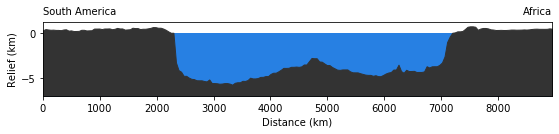

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.text(0, 1.1, "South America", transform=ax.transAxes)
ax.text(1, 1.1, "Africa", horizontalalignment="right", transform=ax.transAxes)
max_depth = -7
profile_bounds = [topo_profile.distance.min(), topo_profile.distance.max()]
ax.fill_between(profile_bounds, [0, 0], max_depth, color='#2780E3')
ax.fill_between(topo_profile.distance, topo_profile.scalars, max_depth, color='#333333')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.tight_layout(h_pad=0, pad=0)
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout()
plt.savefig("topography-profile.png", dpi=200)
plt.show()

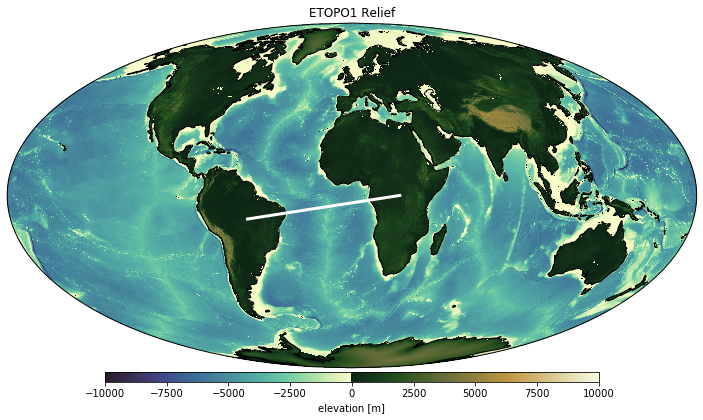

In [7]:
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Mollweide())
ax.set_title("ETOPO1 Relief")
tmp = ax.pcolormesh(
    topo.lon, topo.lat, topo.values, 
    transform=ccrs.PlateCarree(), 
    vmin=-10000, vmax=10000, 
    cmap=cmocean.cm.topo
)
plt.colorbar(tmp, label="elevation [m]", orientation="horizontal", aspect=50, pad=0.01, shrink=0.7)
ax.plot(topo_profile.easting, topo_profile.northing, "-w", linewidth=3, transform=ccrs.PlateCarree())
ax.coastlines()
plt.subplots_adjust(top=0.95, bottom=0, right=0.99, left=0.01, hspace=0, wspace=0)
plt.savefig("topography-profile-location.png", dpi=200)
plt.show()

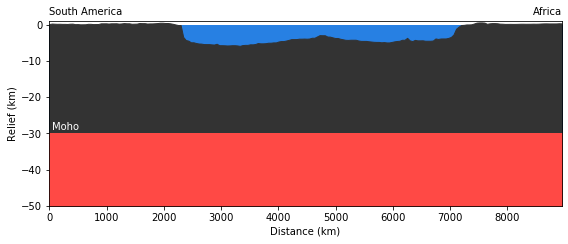

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5))
moho = -30
max_depth = -50
ax.text(0, 1.03, "South America", transform=ax.transAxes)
ax.text(1, 1.03, "Africa", horizontalalignment="right", transform=ax.transAxes)
ax.text(50, -29, "Moho", color="white")
ax.fill_between(profile_bounds, [0, 0], max_depth, color='#2780E3')
ax.fill_between(topo_profile.distance, topo_profile.scalars, moho, color='#333333')
ax.fill_between(profile_bounds, [moho, moho], max_depth, color='#ff4945')
ax.set_ylabel('Relief (km)')
ax.set_xlabel('Distance (km)')
plt.tight_layout(h_pad=0, pad=0)
plt.xlim(*profile_bounds)
plt.ylim(max_depth, topo_profile.scalars.max() + 0.5)
plt.tight_layout()
plt.savefig("topography-profile-hypothesis.png", dpi=200)
plt.show()